In [7]:
import pandas as pd
import numpy as np
# import database as db
import seaborn as sns
import matplotlib.pyplot as plt

import anomaly_detection as ao

sns.set()

In [2]:
def run_anomalies(df, run_date, thresold=95, horizon=12, simulations=10, limit=95):   

    all_forcs = ao.anomaly_wrapper(df, run_date, horizon,
                                   simulations=simulations)

    forcs_df = (all_forcs.groupby(['region', 'cutoff', 'ds'])
                ['percent_ill']
                .describe(percentiles=[.025, 0.05, .1, .25, .5, .75, .9, .95, .975])
                .reset_index())

    # Be sure to grab the correct percentile...
    limit_dict = {90: '95%', 95: '97.5%'}

    forcs_df = forcs_df.merge(df[['region', 'percent_ill', 'ds']],
                              on=['region', 'ds'], how='outer')

    forcs_df['anomaly_diff'] = (forcs_df['percent_ill']
                                - forcs_df[limit_dict[limit]])
    forcs_df['anomaly_ili'] = np.where(forcs_df['anomaly_diff'] > 0,
                                       forcs_df['percent_ill'], np.nan)

    # Only keep the significant anomaly differences
    forcs_df['anomaly_diff'] = (forcs_df['anomaly_ili'] -
                                forcs_df[limit_dict[limit]])
    forcs_df['anomaly_diff'] = forcs_df['anomaly_diff'].fillna(0)
    
    return forcs_df


In [3]:
# Create the Brooklyn, NY ensemble forecasting and anomaly detection example...
ili_df = pd.read_csv('kings_ny.csv')
ili_df['ds'] = pd.to_datetime(ili_df['date'])
ili_df['doy'] = ili_df.ds.dt.dayofyear

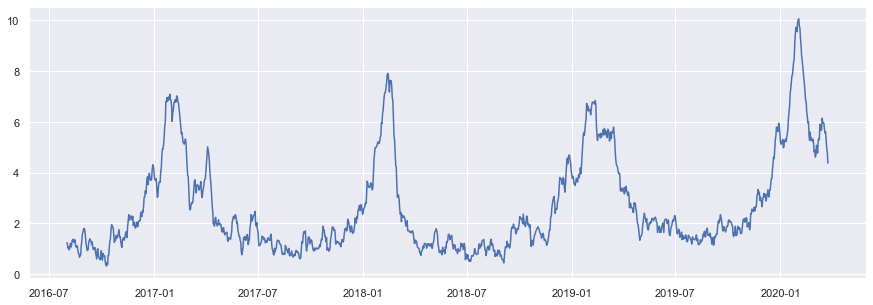

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(ili_df['ds'], ili_df['percent_ill'])

In [5]:
test = run_anomalies(ili_df, ['2020-03-01'], simulations=100)

Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


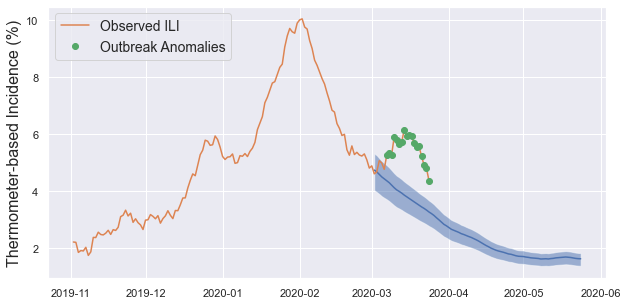

In [6]:
# Figure 1: Example detection in Brooklyn, NY
sub = test[test.ds > '2019-11-01'].copy()
sub.sort_values('ds', inplace=True)

plt.figure(figsize=(10, 5))
plt.fill_between(sub.ds, sub['97.5%'], sub['2.5%'], alpha=0.5)
plt.plot(sub.ds, sub['50%'], label='')
plt.plot(sub.ds, sub.percent_ill, label='Observed ILI')
plt.plot(sub.ds, sub.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

plt.ylabel('Thermometer-based Incidence (%)', fontsize=16)
plt.legend(fontsize=14, loc='upper left');

In [67]:
sub

,index,region,cutoff,ds,count,mean,std,min,2.5%,5%,...,25%,50%,75%,90%,95%,97.5%,max,percent_ill,anomaly_diff,anomaly_ili
0,0,36047,2020-03-01,2020-03-02,10.0,4.610357,0.391273,4.043704,4.072979,4.102255,...,4.248999,4.656284,4.963060,5.035062,5.047761,5.054111,5.060460,4.612264,0.000000,NaN
1,1,36047,2020-03-01,2020-03-03,10.0,4.546831,0.392072,3.979022,4.008357,4.037693,...,4.184736,4.592852,4.900254,4.972403,4.985128,4.991490,4.997853,4.680550,0.000000,NaN
2,2,36047,2020-03-01,2020-03-04,10.0,4.463914,0.382157,3.910465,3.939058,3.967652,...,4.110976,4.508772,4.808400,4.878724,4.891127,4.897329,4.903531,5.074254,0.176925,5.074254
3,3,36047,2020-03-01,2020-03-05,10.0,4.377115,0.375229,3.833698,3.861773,3.889848,...,4.030575,4.421159,4.715355,4.784405,4.796583,4.802672,4.808762,4.993733,0.191061,4.993733
4,4,36047,2020-03-01,2020-03-06,10.0,4.312010,0.369890,3.776326,3.804001,3.831677,...,3.970401,4.355427,4.645438,4.713505,4.725510,4.731512,4.737515,4.770884,0.039371,4.770884
5,5,36047,2020-03-01,2020-03-07,10.0,4.251225,0.364415,3.723469,3.750735,3.778001,...,3.914672,4.294000,4.579718,4.646778,4.658605,4.664519,4.670433,5.260356,0.595837,5.260356
6,6,36047,2020-03-01,2020-03-08,10.0,4.179336,0.358373,3.660331,3.687144,3.713958,...,3.848363,4.221401,4.502382,4.568329,4.579961,4.585776,4.591592,5.329866,0.744089,5.329866
7,7,36047,2020-03-01,2020-03-09,10.0,4.094245,0.351051,3.585843,3.612109,3.638375,...,3.770034,4.135451,4.410691,4.475291,4.486684,4.492381,4.498078,5.290942,0.798560,5.290942
8,8,36047,2020-03-01,2020-03-10,10.0,4.007580,0.343612,3.509951,3.535661,3.561370,...,3.690239,4.047913,4.317321,4.380552,4.391705,4.397281,4.402857,5.906055,1.508774,5.906055
9,9,36047,2020-03-01,2020-03-11,10.0,3.933559,0.337276,3.445107,3.470342,3.495578,...,3.622070,3.973148,4.237588,4.299653,4.310600,4.316073,4.321547,5.800382,1.484308,5.800382
